In [1]:
%%time
import sys;
#!{sys.executable} -m  pip list --outdated --format=freeze | grep -v '^\-e' | cut -d = -f 1  | xargs -n1 pip install -U
#!{sys.executable} -m pip install --upgrade scikit-learn
#!{sys.executable} -m pip install -r requirements.txt

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10 µs


In [2]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 
bucket = 'fraudjf'
 
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print('Bucket:\n{}'.format(bucket))

Bucket:
fraudjf
CPU times: user 986 ms, sys: 146 ms, total: 1.13 s
Wall time: 3.27 s


In [3]:
%%time
import random
import pandas as pd
raw_data_filename = 'fraud-detection.csv'

s3 = boto3.resource('s3', region_name=region)
#s3.Bucket(bucket).download_file(raw_data_filename, raw_data_filename)
percent_to_read=0.7
fraction_to_read=percent_to_read/100 # Divide by 1000 and not 100 as expected?
nrows=10_000_000# There are 6.3 million lines in the original
df = pd.read_csv('./'+raw_data_filename,nrows=nrows, skiprows=lambda i: i>0 and random.random() > fraction_to_read)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 1000)

print('Length', len(df))
target_col='isFraud'
df

Length 44737
CPU times: user 4.3 s, sys: 190 ms, total: 4.49 s
Wall time: 9.31 s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,C2001112025,25742.00,0.00,0,0
1,1,PAYMENT,2057.71,C896138248,25132.00,23074.29,M548482954,0.00,0.00,0,0
2,1,TRANSFER,55536.86,C332365138,0.00,0.00,C392292416,915902.37,3420103.09,0,0
3,1,CASH_IN,62325.15,C695530017,960786.56,1023111.71,C564160838,1880271.66,1254956.07,0,0
4,1,PAYMENT,598.24,C494953170,102631.00,102032.76,M509864971,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
44732,723,TRANSFER,2232257.71,C546364616,2232257.71,0.00,C877246848,0.00,0.00,1,0
44733,726,TRANSFER,185529.91,C1426277806,185529.91,0.00,C753666064,0.00,0.00,1,0
44734,730,TRANSFER,10000000.00,C507645439,47316255.05,37316255.05,C270374999,0.00,0.00,1,0
44735,739,CASH_OUT,7758036.72,C459813446,7758036.72,0.00,C294714363,47778.61,7805815.33,1,0


In [4]:
fraud_len=len(  df.loc[  df['isFraud']  ==1  ])
not_fraud_len=len(df)-fraud_len
print('Fraud', fraud_len, 'Not fraud', not_fraud_len, "total", len(df))

Fraud 63 Not fraud 44674 total 44737


In [5]:
df=df.drop(['isFlaggedFraud'], axis=1)


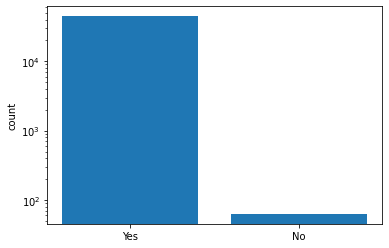

In [6]:
import math
import matplotlib.pyplot as plt   
def plot_positive_negative_counts(df, target_col):
    val_counts=df[target_col].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale="log")
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,target_col)

In [7]:
cols = df.columns.tolist()
cols.remove(target_col)
cols = [target_col] + cols
df = df[cols]# Move target to the left

df_dummies=pd.get_dummies(df['type'],drop_first=True )

df=df.drop(['type'], axis=1)
df = pd.concat([df, df_dummies], axis=1)
 

In [8]:
%%time

#import sys
#!{sys.executable} -m pip install numpy category_encoders

import category_encoders as ce  
hashencode_these = ['nameOrig', 'nameDest']
columns_before = [x for x in df.columns if x not in hashencode_these+[target_col]]

def make_col_mapping(cols):
    col_mapping = {}
    for c in cols:
        if c[:4]=='col_':
          num = c.split('_')[-1]
          int(num) # check format
          col_mapping[c] = hashencode_this + "_" + num
     
    return col_mapping


def hashencode(hashencode_this, df, previous_hash_cols):
    for c in df.columns:
        assert c[:4]!="col_",  df.columns
                
    ce_hash = ce.HashingEncoder(cols = [hashencode_this])
    X1 = df.drop([target_col], axis=1)
    y1 = df.isFraud
    with_hashing = ce_hash.fit_transform(X1, y1)
    hashed = with_hashing.drop(columns_before+previous_hash_cols, axis=1)
    generated_cols = [x for x in hashed.columns if x[:4]=='col_']
    col_mapping = make_col_mapping(generated_cols)
    
    hashed = hashed.rename(columns = col_mapping)
    df = pd.concat([y1, X1, hashed], axis=1)
 
    df = df.drop([hashencode_this], axis=1)
    return df, list(col_mapping.values())
 
previous_hash_cols = []
for hashencode_this in hashencode_these: 
   df, previous_hash_cols = hashencode(hashencode_this,df,previous_hash_cols)

df

CPU times: user 1min 28s, sys: 777 ms, total: 1min 29s
Wall time: 1min 29s


,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,...,nameOrig_6,nameOrig_7,nameDest_0,nameDest_1,nameDest_2,nameDest_3,nameDest_4,nameDest_5,nameDest_6,nameDest_7
0,0,1,23261.30,20411.53,0.00,25742.00,0.00,1,0,0,...,1,0,0,0,0,0,0,0,0,2
1,0,1,2057.71,25132.00,23074.29,0.00,0.00,0,0,1,...,0,0,0,0,0,0,0,0,2,0
2,0,1,55536.86,0.00,0.00,915902.37,3420103.09,0,0,0,...,1,0,0,0,0,0,0,0,0,2
3,0,1,62325.15,960786.56,1023111.71,1880271.66,1254956.07,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,0,1,598.24,102631.00,102032.76,0.00,0.00,0,0,1,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,1,723,2232257.71,2232257.71,0.00,0.00,0.00,0,0,0,...,0,1,0,0,0,0,0,0,0,2
44733,1,726,185529.91,185529.91,0.00,0.00,0.00,0,0,0,...,0,0,0,0,0,0,0,0,2,0
44734,1,730,10000000.00,47316255.05,37316255.05,0.00,0.00,0,0,0,...,0,0,0,0,0,0,0,2,0,0
44735,1,739,7758036.72,7758036.72,0.00,47778.61,7805815.33,1,0,0,...,0,0,0,0,0,0,2,0,0,0


In [9]:
#import sys;
#!{sys.executable} -m pip install numpy imbalanced-learn
from imblearn.over_sampling import SMOTENC

ycol=target_col
Xcol=list(df.columns)
Xcol.remove(ycol)
 
categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

smotenc = SMOTENC(categorical_columns,random_state = 101)

X, y = smotenc.fit_resample(df[Xcol], df[ycol])
y_df = pd.DataFrame({target_col: y} )

df = pd.concat([X, y_df], axis=1)

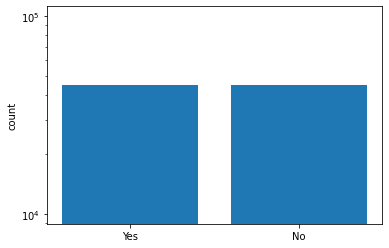

In [10]:
plot_positive_negative_counts(df,target_col)

In [11]:
import numpy as np
len_=len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len_), int(0.9 * len_)])

Amazon SageMaker's version of XGBoost supports input data in both CSV and libSVM data format.  We'll use libSVM here, with features and the target variable provided as separate arguments. To avoid any misalignment issues due to random reordering, this split is done after the previous split in the above cell. As a last step before training, we'll copy the resulting files to S3 as input for Amazon SageMaker's hosted training.

In [24]:
from sklearn.datasets import dump_svmlight_file   

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset=d[0]
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])


for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

In [25]:
def s3_path(subset):
  return sagemaker.s3_input(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

AttributeError: module 'sagemaker' has no attribute 's3_input'

---
## Train

Our data is now ready to be used to train a XGBoost model. The XGBoost algorithm has many tunable hyperparameters. Some of these hyperparameters are listed below; initially we'll only use a few of them.  

- `max_depth`: Maximum depth of a tree. As a cautionary note, a value too small could underfit the data, while increasing it will make the model more complex and thus more likely to overfit the data (in other words, the classic bias-variance tradeoff).
- `eta`: Step size shrinkage used in updates to prevent overfitting.  
- `eval_metric`: Evaluation metric(s) for validation data. For data sets such as this one with imbalanced classes, we'll use the AUC metric.
- `scale_pos_weight`: Controls the balance of positive and negative weights, again useful for data sets having imbalanced classes.

First we'll set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.  The Estimator object from the Amazon SageMaker Python SDK is a convenient way to set up training jobs with a minimal amount of code.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=2.0,
                        num_round=100)


Next, we'll run the hosted training job itself.  The hardware used for the training job is separate from your notebook instance and is managed by Amazon SageMaker, which performs the heavy lifting such as setting up a training cluster and tearing it down when the job is done.  A single line of code starts the training job.

In [ ]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

---
## Host

Now that we've trained the XGBoost algorithm on our data, we can deploy the trained model to an Amazon SageMaker hosted endpoint with one simple line of code.

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                          instance_type='ml.m5.xlarge')

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from it. More specifically, let's generate predictions from our test data set to understand how well our model generalizes to data it has not seen yet.

There are many ways to compare the performance of a machine learning model.  We'll start simply by comparing actual to predicted values of whether the ticket was a "success" (`1`) or not (`0`).  Then we'll produce a  confusion matrix, which shows how many test data points were predicted by the model in each category versus how many test data points actually belonged in each category.

In [ ]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [ ]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

print ('\nError rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

In [ ]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

---
## Extensions

This XGBoost model is just the starting point for predicting whether a game will be a hit based on reviews and other attributes.  There are several possible avenues for improving the model's performance.  First, of course, would be to collect more data and, if possible, fill in the existing missing fields with actual information.  Another possibility is further hyperparameter tuning using Amazon SageMaker's Automatic Model Tuning feature.  Examples of using this feature can be found in the [hyperparameter tuning directory of the SageMaker Examples GitHub repository](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning) and the **SageMaker Examples** tab of Amazon SageMaker notebook instances.  And, although ensemble learners often do well with imbalanced data sets, it could be worth exploring techniques for mitigating imbalances such as downsampling, synthetic data augmentation, and other approaches.  

---
## Cleanup

If you are finished with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
session.delete_endpoint(xgb_predictor.endpoint)